In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pylab as plt

from collections import OrderedDict

# Data

ZetaValue에서 제공하는 샘플 주가 데이터를 사용합니다.

In [2]:
df = pickle.load(open('../Data/000660.pkl', 'rb'))
df = df[df.index >= '2017-01-01']

# 보기 편하게 resample 함
OHLCV_AGG = OrderedDict((
    ('Open', 'first'),
    ('High', 'max'),
    ('Low', 'min'),
    ('Close', 'last'),
    ('Volume', 'sum'),
    ('NetPrice', 'sum')
))
week_df = df.resample('W').agg(OHLCV_AGG)
display(week_df.tail())

,Open,High,Low,Close,Volume,NetPrice
Date,,,,,,
2021-07-04,129000.0,129500.0,121500.0,122500.0,16280424.0,2046654.0
2021-07-11,123500.0,126000.0,118000.0,119500.0,13917955.0,1694363.0
2021-07-18,121000.0,124000.0,119500.0,121500.0,12205887.0,1489661.0
2021-07-25,119000.0,120000.0,116500.0,118500.0,10668197.0,1263510.0
2021-08-01,119500.0,120000.0,117000.0,117000.0,1818451.0,214538.0


# BARS

1. Time Bar 
    - 일반적인 시가, 고가, 저가, 종가, 볼륨 데이터를 의미 
    - 문제점은 시간에 따라서 다른 패턴을 보입니다. 예를 들어 장시작후 10분이 오후 12시쯤의 거래와 비교하면 훨씬 액티브 합니다. 
    - 즉 low activity period 에는 oversampling이 되고, high-activity period 에는 undersampling이 됩니다. 
2. Tick Bar
    - 단순 거래횟수를 기준으로 삼는 것
    - Trading Activity를 판단할 수 있다
    - 단점은 100개의 주식을 사도 -> 하나의 거래로 처리 되기 때문에 Volume에 대한 정보 손실이 있다
3. Volume Bar 
    - Tick Bar의 단점을 보완한다
    - X축이 일정양의 Volume을 의미한다
4. Dollar Bar 
    - 같은 1000만원이더라도 주가에 따라서 수량이 크게 차이가 날수 있다. 
    - Dollar Bar는 이러한 문제를 해결한다
    
    
사실.. Time Bar의 진짜 문제점은.. 헤지펀드사의 Fake 데이터입니다.<br>
일반적인 retail trader가 대부분 어떤 알고리즘으로 짜여져 있는지 알고 있으며, <br>
가짜 주문, 가짜 volume을 만들어내서 RSI 또는 Bollinger Bands를 속입니다. 


https://towardsdatascience.com/information-driven-bars-for-financial-machine-learning-imbalance-bars-dda9233058f0

구현부분 참고
https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba

## Volume Bar (Pandas 구현)

Pandas로 구현하는 방법은 사실 좀 부정확하다.<br>
GroupBy해서 하는 방법인데.. 맞지가 않다 <br>
다만 참고사항으로 넣어둠

In [3]:
def bar(x, n):
    return np.int64(x / n)


VOLUME_OHLCV_AGG = OrderedDict((
    ('Open', 'first'),
    ('High', 'max'),
    ('Low', 'min'),
    ('Close', 'last'),
    ('Volume', 'sum'),
    ('NetPrice', 'sum'),
    ('Date', 'last')
))

volume_df = (week_df
             .reset_index()
             .groupby(bar(week_df.Volume.cumsum(), 20000000))
             .agg(VOLUME_OHLCV_AGG))
volume_df.index.name = 'VolumeBar'
volume_df.reset_index(inplace=True)
volume_df.set_index('Date', inplace=True)

print(volume_df.shape)
volume_df.tail()

(193, 7)


,VolumeBar,Open,High,Low,Close,Volume,NetPrice
Date,,,,,,,
2021-06-20,212,129500.0,130000.0,120500.0,124500.0,32768618.0,4123962.0
2021-06-27,213,121000.0,129000.0,120500.0,128500.0,13336083.0,1656075.0
2021-07-11,214,129000.0,129500.0,118000.0,119500.0,30198379.0,3741017.0
2021-07-18,215,121000.0,124000.0,119500.0,121500.0,12205887.0,1489661.0
2021-08-01,216,119000.0,120000.0,116500.0,117000.0,12486648.0,1478048.0


## Volume Bar (Python 구현)

In [4]:
def build_bar(df_:pd.DataFrame, colume:str, size:int):
    _sum = 0
    data = []
    for i, row in df_.iterrows():
        _sum += row[colume]
        if _sum >= size:
            data.append(row)
            # 이부분을 _sum -= size 로 구현할수도 있다
            _sum = 0
    return pd.DataFrame(data)

volume_df = build_bar(week_df, 'Volume', 10000000)
print(volume_df.shape)
volume_df.tail()

(225, 6)


,Open,High,Low,Close,Volume,NetPrice
2021-06-27,121000.0,129000.0,120500.0,128500.0,13336083.0,1656075.0
2021-07-04,129000.0,129500.0,121500.0,122500.0,16280424.0,2046654.0
2021-07-11,123500.0,126000.0,118000.0,119500.0,13917955.0,1694363.0
2021-07-18,121000.0,124000.0,119500.0,121500.0,12205887.0,1489661.0
2021-07-25,119000.0,120000.0,116500.0,118500.0,10668197.0,1263510.0


## Tick Bar

원래 Intraday 거래 기준으로 하면, 장시작후 시간, 오후, 장마감 때의 tick의 분포가 달라지기 나타나는데.. <br>
현재 사용한 데이터는 weekly기준이기 때문에 기존 Time Bar와 별 차이가 없게 느껴질수 있다. 

In [5]:
week_df['tick'] = 1
tick_df = build_bar(week_df, 'tick', 5)
print(tick_df.shape)
tick_df.tail()

(47, 7)


,Open,High,Low,Close,Volume,NetPrice,tick
2021-02-14,127500.0,130000.0,124500.0,126000.0,12316092.0,1559820.0,1.0
2021-03-21,141500.0,145000.0,136000.0,138000.0,18625337.0,2606708.0,1.0
2021-04-25,138000.0,139000.0,128500.0,132500.0,17056960.0,2286814.0,1.0
2021-05-30,122000.0,126500.0,119000.0,125000.0,16334658.0,2010538.0,1.0
2021-07-04,129000.0,129500.0,121500.0,122500.0,16280424.0,2046654.0,1.0


## Dollar Bar

In [6]:
price_df = build_bar(df, 'NetPrice', 1000000)
print(price_df.shape)
price_df.tail()

(300, 6)


,Open,High,Low,Close,Volume,NetPrice
2021-06-30,126500.0,129500.0,126000.0,127500.0,4346027.0,557285.0
2021-07-05,123500.0,124500.0,122500.0,123000.0,1632551.0,201788.0
2021-07-09,120500.0,120500.0,118000.0,119500.0,4823577.0,572864.0
2021-07-15,123500.0,124000.0,122500.0,123500.0,1500981.0,185186.0
2021-07-21,119500.0,120000.0,116500.0,117000.0,2864601.0,336751.0


## 시각화

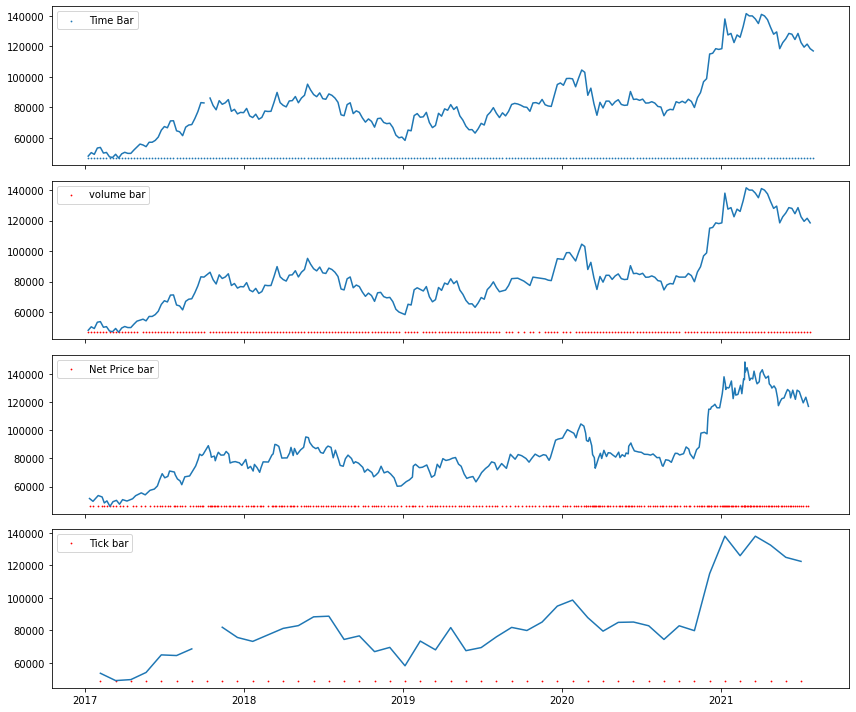

In [7]:
fig, ax = plt.subplots(4, sharex=True, figsize=(12, 10))
fig.set_tight_layout(True)

# Time Bar
ax[0].plot(week_df.Close)
ax[0].scatter(week_df.index, [week_df.Close.min()] * week_df.shape[0], 0.6, label='Time Bar')
ax[0].legend()

# Volume Bar
ax[1].plot(volume_df.Close)
ax[1].scatter(volume_df.index, 
              [volume_df.Close.min()] * volume_df.shape[0], 
              0.6, color='red', label='volume bar')
ax[1].legend()

# Dollar Bar
ax[2].plot(price_df.Close)
ax[2].scatter(price_df.index, 
              [price_df.Close.min()] * price_df.shape[0], 
              0.6, color='red', label='Net Price bar')
ax[2].legend()

# Tick Bar
ax[3].plot(tick_df.Close)
ax[3].scatter(tick_df.index, 
              [tick_df.Close.min()] * tick_df.shape[0], 
              0.6, color='red', label='Tick bar')
ax[3].legend()

# Tick Imbalance Bar 

## Tick Rule 


몇몇 헤지펀드에 의해서, volume이 조작될 수 있다고 언급했습니다. <br>
Tick Imbalance는 이러한 문제를 해결하기 위해서.. 얼마나 많은 주문들이 (얼마나 많은 informed traders가..) <br>
높은 가격 또는 낮은 가격에 베팅하고 있는지를 나타내는 것입니다. <br>
한국형으로 바꾸려면.. 단주 주문(주문 1개만 넣는것)은 제외하고 넣는게 좋습니다. 


1. 만약 가격이 이전 가격보다 더 높아졌다면, signed tick 을 1 로 잡습니다. 
2. 만약 가격이 이전 가격보다 더 낮아졌다면, signed tick 을 -1 로 잡습니다 .
3. 만약 가격이 이전 가격과 동일하다면, 이전의 signed tick값을 그대로 사용합니다. 

$$ b_t = \begin{cases} b_{t-1} & \text{ if } \Delta P_t = 0 \\ \frac{|\Delta P_t|}{ \Delta P_t} & \text{ if } \Delta P_t \ne 0 \end{cases} $$

 - $ \Delta P_t $ : 가격의 변화입니다. (현재가격 - 이전가격)
 - $ b_t $ : signed tick 으로서 $ b_t \in \{ -1, 1\} $ 입니다.
 
## Tick Imbalance Bar (TIBs)

**Cumulative Sum of Signed Tick**은 다음과 같이 계산합니다. 

$$ \theta_T = \sum^T_{t=1} b_t $$

의미하는 바는 결국 +1 아니면 -1 의 연속된 값을 cumulative sum으로 계산하겠다는 것인데.. <br>
얼마나 많은 거래들이 bullish인지  또는 얼마나 많은 거래들이 bearish 인지 나타내는 지표를 만드는 것입니다. <br>
이것은 Volume기반과는 다를수 있습니다. <br>
Python 에서는 그냥 `imb_ticks.cumsum()` 하면 됩니다.

In [180]:
def calculate_tick_direction(prices):
    imb_ticks = np.zeros_like(prices)
    for i in range(1, len(prices)):
        diff = prices[i] - prices[i-1]
        if diff == 0:
            b = imb_ticks[i-1]
        else:
            b = np.abs(diff) / diff
            
        imb_ticks[i] = b
    imb_ticks[0] = imb_ticks[1]
    return pd.Series(imb_ticks, index=prices.index)

def calculate_imbalance(bs:pd.Series, ET_init:int):
    n = bs.shape[0]
    T, T_index = [], []
    
    thresholds = np.zeros(n)
    i_prev = 0
    E_T = ET_init
    E_b = bs.ewm(30).mean() #abs(bs.mean())
    theta = bs.cumsum().abs()
    for i in range(1, n):
        thresholds[i] = E_T * abs(E_b[i])
        
        if abs(theta[i]) >= thresholds[i]:
            T.append(i - i_prev + 1)
            T_index.append(bs.index[i])
            i_prev = i

            E_T = pd.Series(T, index=T_index).ewm(len(T)).mean()[-1]
            # E_b = abs(bs[:i].ewm(len(bs)).mean()[-1])
    T = pd.Series(T, index=T_index)
    thresholds = pd.Series(thresholds, index=bs.index)
    return T, theta, thresholds
    

sample_df = df[df.index >= '2020-01-01']
bs = calculate_tick_direction(sample_df.Close)

bvs = bs * sample_df.Volume

T, theta, thresholds = calculate_imbalance(bvs, 100)
print(thresholds)
# Expected value of bs approximated by ewm
# rolling_size = imb_ticks.shape[0]// 100
# E_bs = imb_ticks.ewm(rolling_size).mean()

# # Expected value of T
# E_T = pd.Series(range(bs.shape[0]), index=bs.index).ewm(rolling_size).mean()





Date
2020-01-02    0.000000e+00
2020-01-03    2.687293e+08
2020-01-06    2.649514e+08
2020-01-07    2.607503e+08
2020-01-08    5.548259e+07
                  ...     
2021-07-20    5.620900e+05
2021-07-21    7.435045e+05
2021-07-22    5.855922e+05
2021-07-23    6.883258e+05
2021-07-26    7.926239e+05
Length: 389, dtype: float64


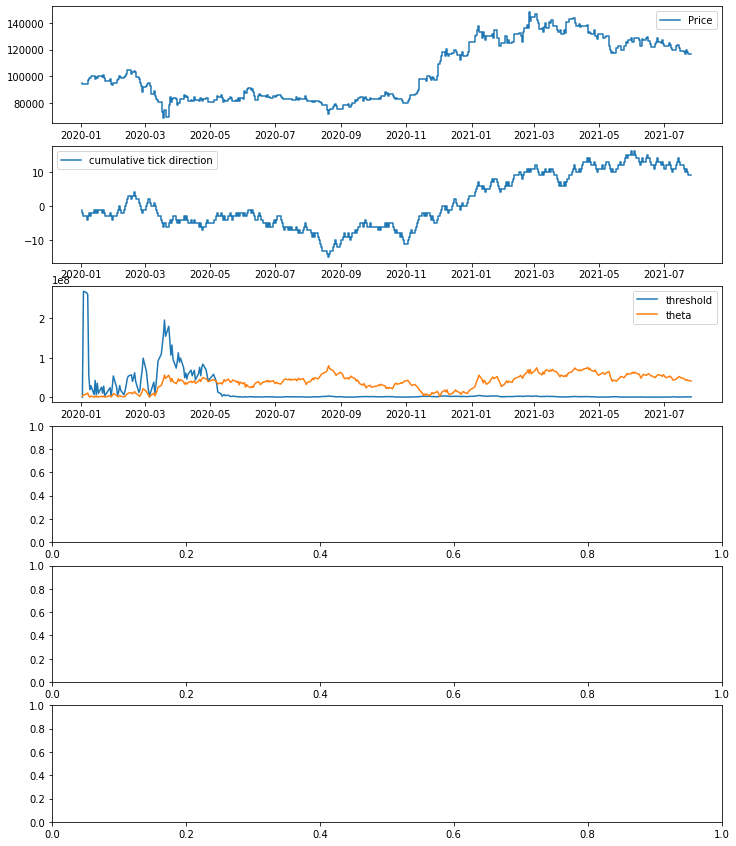

In [182]:
# 시각화
fig, ax = plt.subplots(6, figsize=(12, 15))
ax[0].step(sample_df.index, sample_df.Close, label='Price')
ax[0].legend()

ax[1].step(bs.index, bs.cumsum(), label='cumulative tick direction')
ax[1].legend()


# diff_df = sample_df.Close.pct_change() - tick_direction.cumsum().pct_change()
# ax[2].fill_between(diff_df.index, 0, diff_df,
#                    label='difference between price and imbalance tick')
# ax[2].legend()

ax[2].plot(thresholds, label='threshold')
ax[2].plot(theta, label='theta')
ax[2].legend()
# ax[2].plot(E_bs, color='purple', label='E_bs - signed tick imbalance (EWA)')


# ax[3].plot(E_T, color='purple', label='E_T - ')
# ax[3].legend()

True